### Problem Statement

The mushrooms dataset contains details about different mushroom types. The aim is to determine whether a mushroom is of class `e` = edible, or class `p` = poisonous.

I'll fit an XGBoost model in order to demonstrate the use of SHAP values for model interpretability.

### Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
from sklearn import metrics

pd.options.display.max_columns = None

### Import Data

In [3]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [4]:
print(f'number of records: {len(df)}')
print(f'number of columns: {len(df.columns)}')

number of records: 8124
number of columns: 23


In [5]:
df.drop(columns=['veil-type'],inplace=True)

In [6]:
model_data = df.copy()

In [7]:
model_data['target'] = np.where(model_data['class']=='p'
                               ,1
                               ,0)

In [8]:
model_data = pd.get_dummies(model_data.drop(columns='class'))

### Prepare Model Data

In [9]:
target = 'target'
features = model_data.drop(columns='target').columns

In [10]:
train, valid = train_test_split(model_data, test_size=0.3, random_state=1, stratify=model_data[target])
valid, test = train_test_split(valid, test_size=0.5, random_state=1, stratify=valid[target])

In [11]:
print(f'train: {len(train)} {train[target].sum()/len(train)}')
print(f'validation: {len(valid)} {valid[target].sum()/len(valid)}')
print(f'test: {len(test)} {test[target].sum()/len(test)}')

train: 5686 0.4820612029546254
validation: 1219 0.4815422477440525
test: 1219 0.48236259228876127


### Model Fit - XGBoost

In [12]:
xgb_model = xgb.XGBClassifier()

In [13]:
xgb_model.fit(train[features], train[target])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [14]:
valid_y_pred = xgb_model.predict(valid[features])

In [15]:
print("Accuracy:",metrics.accuracy_score(valid[target], valid_y_pred))

Accuracy: 1.0


In [16]:
print(metrics.confusion_matrix(valid[target], valid_y_pred))

[[632   0]
 [  0 587]]


In [17]:
print(metrics.classification_report(valid[target], valid_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       632
           1       1.00      1.00      1.00       587

    accuracy                           1.00      1219
   macro avg       1.00      1.00      1.00      1219
weighted avg       1.00      1.00      1.00      1219



In [20]:
explainer = shap.TreeExplainer(xgb_model)

In [21]:
shap_values = explainer.shap_values(train[features])

The feature which indicates if a mushroom has an odour is the most important feature in the model by far.

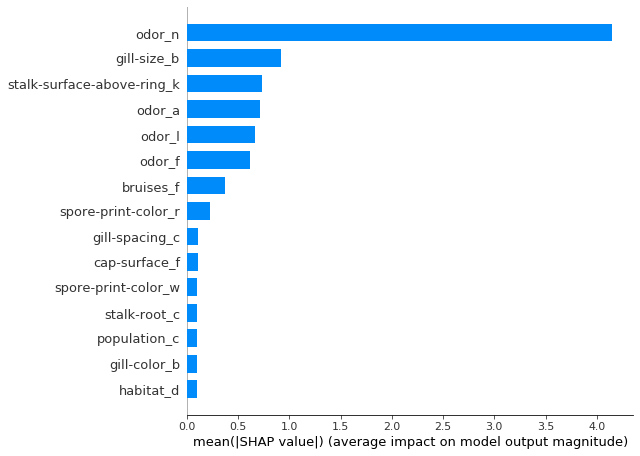

In [22]:
shap.summary_plot(shap_values, train[features], plot_type="bar",max_display=15)

In [27]:
model_data.groupby('odor_n').target.mean()

odor_n
0    0.825936
1    0.034014
Name: target, dtype: float64

The feature `odor_n` is boolean which means it only has two values: 1 or 0. In this case, a value of 1 means the mushroom has no odour.

The below graph shows that a high value of `odor_n` (meaning `odor_n` = 1 i.e. the mushroom has no odour) is correlated with a lower prediction of being poisonous. Hence, if a mushroom has an odour then it is likely to be poisonous.

There are many other features which show a clear cut correlation with the target variable. The second most important feature in the model is `gill-size_b`: this indicates whether the gill size is broad. Again, this is a boolean variable and a high value is correlated with a lower likelihood of the mushroom being poisonous i.e. if the mushroom has broad gills, then it's likely to be edible.

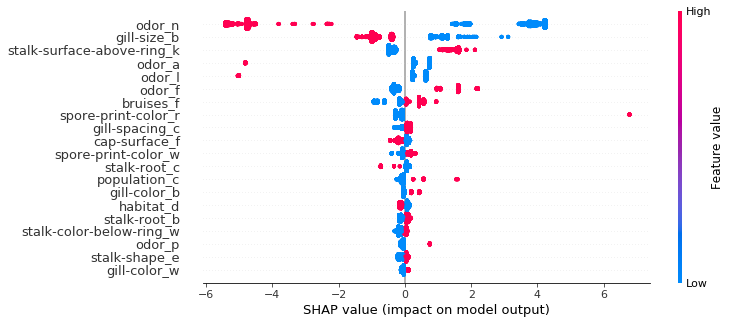

In [23]:
shap.summary_plot(shap_values, train[features], max_display=20,show=False, plot_size=(10,5))

The below graph does not show much of interest but I wanted to demonstrate that plotting a dependence plot of a particular feature will also show its relationship with the feature it interacts with most.

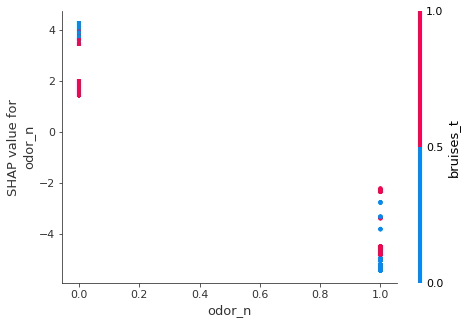

In [26]:
shap.dependence_plot('odor_n', shap_values, train[features])
plt.show()